# Figure 1

Start by loading some boiler plate: matplotlib, numpy, scipy, json, functools, and a convenience class.

In [1]:
%matplotlib inline
import matplotlib
matplotlib.rcParams['figure.figsize'] = (10.0, 8.0)
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import interp1d, InterpolatedUnivariateSpline
from scipy.optimize import bisect
import json
from functools import partial
class Foo: pass

And some more specialized dependencies:
 1. ``Slict`` provides a convenient slice-able dictionary interface
 2. ``Chest`` is an out-of-core dictionary that we'll hook directly to a globus remote using...
 3. ``glopen`` is an open-like context manager for remote globus files

In [2]:
from chest import Chest
from slict import CachedSlict
from glopen import glopen, glopen_many

Configuration for this figure.

In [3]:
config = Foo()
config.name0     = "HighAspect/HA_base/HA_base"
config.name1     = "HighAspect/HA_visc/HA_visc"
#config.arch_end = "maxhutch#alpha-admin/~/pub/"
config.arch_end = "alcf#dtn_mira/projects/alpha-nek/"

Open a chest located on a remote globus endpoint and load a remote json configuration file.

In [4]:
c0 = Chest(path      = "{:s}-results".format(config.name0),
          open      = partial(glopen,      endpoint=config.arch_end),
          open_many = partial(glopen_many, endpoint=config.arch_end))
sc0 = CachedSlict(c0)
with glopen(
            "{:s}.json".format(config.name0), mode='r',
            endpoint = config.arch_end,
            ) as f:
    params0 = json.load(f)

In [5]:
c1 = Chest(path      = "{:s}-results".format(config.name1),
          open      = partial(glopen,      endpoint=config.arch_end),
          open_many = partial(glopen_many, endpoint=config.arch_end))
sc1 = CachedSlict(c1)
with glopen(
            "{:s}.json".format(config.name1), mode='r',
            endpoint = config.arch_end,
            ) as f:
    params1 = json.load(f)

We want to plot the spike depth, which is the 'H' field in the chest.
Chests can prefetch lists of keys more quickly than individual ones, so we'll prefetch the keys we want.

In [6]:
c0.prefetch(sc0[:,'H'].full_keys())
c0.prefetch(sc0[:,'w_max_z'].full_keys())
c1.prefetch(sc1[:,'H'].full_keys())
c1.prefetch(sc1[:,'w_max_z'].full_keys())

Plot the bubble height, the 'H' keys, vs. time.
Use a spline to compute the derivative.

In [7]:
spl0 = InterpolatedUnivariateSpline(sc0[:,'H'].keys(), sc0[:,'H'].values(), k=3)
dHdt0 = spl0.derivative()
Ts0 = np.linspace(sc0[:,'H'].keys()[0], sc0[:,'H'].keys()[-1], 1000)
Vb0 = -dHdt0(Ts0)
Vm0 = np.array([np.max(sc0[t,'w_max_z']) for t in sc0[:,'w_max_z'].keys()])
Vc0 = np.array([sc0[t,'w_max_z'][sc0[t,'w_max_z'].shape[0]/2] for t in sc0[:,'w_max_z'].keys()])
theory0 = np.sqrt(
                  params0["atwood"] * params0["g"] * params0["extent_mesh"][0] / np.pi 
                + (2.*np.pi*params0["viscosity"] / params0["extent_mesh"][0])**2
                ) - (2.*np.pi*params0["viscosity"] / params0["extent_mesh"][0]) 

In [8]:
spl1 = InterpolatedUnivariateSpline(sc1[:,'H'].keys(), sc1[:,'H'].values(), k=3)
dHdt1 = spl1.derivative()
Ts1 = np.linspace(sc1[:,'H'].keys()[0], sc1[:,'H'].keys()[-1], 1000)
Vb1 = -dHdt1(Ts1)
Vm1 = np.array([np.max(sc1[t,'w_max_z']) for t in sc1[:,'w_max_z'].keys()])
Vc1 = np.array([sc1[t,'w_max_z'][sc1[t,'w_max_z'].shape[0]/2] for t in sc1[:,'w_max_z'].keys()])
theory1 = np.sqrt(
                  params1["atwood"] * params1["g"] * params1["extent_mesh"][0] / np.pi 
                + (2.*np.pi*params1["viscosity"] / params1["extent_mesh"][0])**2
                ) - (2.*np.pi*params1["viscosity"] / params1["extent_mesh"][0]) 

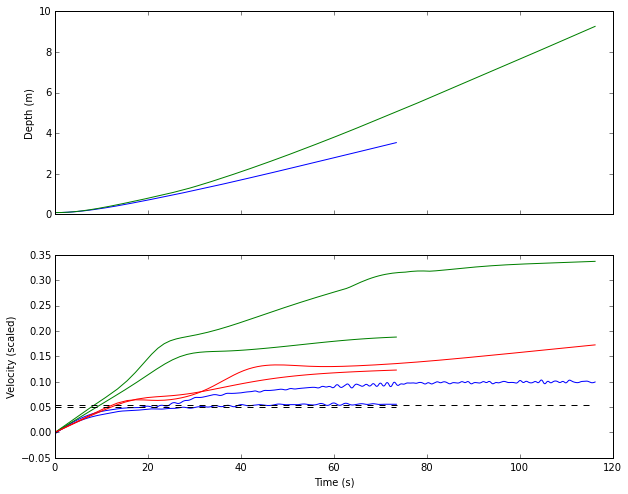

In [9]:
fig, axs = plt.subplots(2,1, sharex=True)

axs[0].plot(Ts0, -spl0(Ts0));
axs[0].plot(Ts1, -spl1(Ts1));
#axs[0].plot(sc[:,'H'].keys(), -np.array(sc[:,'H'].values()), 'yo');
axs[0].set_ylabel('Depth (m)')

axs[1].plot(Ts0, Vb0, 'b-');
axs[1].plot(Ts1, Vb1, 'b-');
axs[1].plot(sc0[:,'w_max_z'].keys(), Vm0, 'g-');
axs[1].plot(sc1[:,'w_max_z'].keys(), Vm1, 'g-');
axs[1].plot(sc0[:,'w_max_z'].keys(), Vc0, 'r-');
axs[1].plot(sc1[:,'w_max_z'].keys(), Vc1, 'r-');
axs[1].plot([Ts0[0],Ts0[-1]], [theory0, theory0], 'k--');
axs[1].plot([Ts1[0],Ts1[-1]], [theory1, theory1], 'k--');
axs[1].set_ylabel('Velocity (scaled)')
axs[1].set_xlabel('Time (s)');
plt.savefig('Figure1.eps')

In [10]:
%install_ext http://raw.github.com/jrjohansson/version_information/master/version_information.py 
%load_ext version_information 
%version_information numpy, matplotlib, slict, chest, glopen, globussh

Installed version_information.py. To use it, type:
  %load_ext version_information


Software versions
Python 3.4.3 64bit [GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]
IPython 3.0.0
OS Linux 3.2.0 4 amd64 x86_64 with debian 7.8
numpy 1.9.2
matplotlib 1.4.3
slict 0.2.5
chest 0.2.2
glopen 0.0.12
globussh 0.1.1
Mon Apr 27 08:09:24 2015 CDT